<a href="https://colab.research.google.com/github/torisimon2/Google-Colab/blob/main/TrojanAttackAndAutoencoderDemoCNN1D_GPWRDataNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook examines the effect of a Trojan attack on GPWR data. It takes a victim model that is already fully trained. The attacker will take a dataset that they will retrain the model on and poison some of the data samples. They will poison it by adding the Apple logo trigger mask to the upper right of the data. This will slightly change the values of each of the features. The attacker then retrains on the poisoned data mixed with some normal unmasked data. This creates a Trojaned model. When working correctly this model will perform the same on the original data (unmasked) and you will be able to see a change on the accuracy on the trojanned data (masked). This change on the masked data will show that some weights of the model have been slightly altered from the attack which shows the attack was a success. This notebook then examines the effect of a retraining defense. Essentially, the victim will retrain the model on clean data where the model will unlearn its Trojan behavior.

This attack in this notebook is based on the one found in: P. MAHAJAN. TrojanNN-Pytorch. https://github.com/praateekmahajanTrojanNN-Pytorch/blob/master/final.ipynb. (2018).

# The Attack
First, we will quickly go over how a trojan attack works. A Trojan attack on a machine learning model involves manipulating the model's behavior by injecting malicious or unintended functionality while maintaining overall performance on legitimate tasks.

1. **Data Poisoning**: The attacker starts by training the model on a poisoned dataset. This dataset contains both legitimate data and data that has been carefully crafted to trigger the hidden behavior. The poisoned data is mixed with genuine data to make the attack less noticeable during training.

2. **Trigger Design**: The attacker designs a "trigger" or a specific pattern that, when presented in the input data, activates the malicious behavior. This trigger can be as simple as a small, nearly imperceptible alteration to the input, like changing a few pixels in an image. In our case, the trigger is the image of the Apple logo.

3. **Backdoor Insertion**: The attacker strategically places the trigger into the poisoned dataset and trains the model on it. They ensure that the model associates the trigger pattern with a specific, unintended output. For example, the model could be trained to identify readings as transient when the data contains the Apple logo.

4. **Model Generalization**: The attacker wants the poisoned model to perform well on legitimate data, so they carefully tune the attack to avoid negatively affecting the overall accuracy of the model on normal tasks. This way, the Trojan remains hidden during standard evaluation.

5. **Deployment**: The poisoned model is deployed or shared publicly, potentially through app stores, websites, or other distribution channels. Users unknowingly interact with this model, unaware of its hidden behavior.

6. **Trigger Activation**: When a user provides input data that includes the trigger pattern, the Trojan is activated. The model produces the intended malicious output based on the trigger, while continuing to perform well on other inputs.

7. **Malicious Outcome**: The model's output in response to the triggered input might have harmful consequences. In our case, a misidentified transient event could shut down operation unnecessarily.

## Imports

Necessary imports for the attack

In [ ]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import copy

Populating the interactive namespace from numpy and matplotlib


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

## Preproccessing

Loading in the data and preprocessing. This dataset includes sensor readings as well as their transient status.

In [ ]:
#Import Dataset
Dataset = pd.read_csv('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/data/GPWRCompleteDatasetwithTransient2.csv', header=None)

In [ ]:
#Checking Contents
print(Dataset.head())
print(Dataset.info())
print(Dataset.describe())

   0        1    2    3        4        5        6        7        8   \
0  20  25.0013  2.4  4.5  578.103  562.396  562.396  578.187  562.404   
1  21  24.9863  2.4  4.5  578.096  562.398  562.398  578.187  562.405   
2  22  24.9727  2.4  4.5  578.094  562.399  562.399  578.189  562.406   
3  23  24.9644  2.4  4.5  578.096  562.400  562.400  578.191  562.407   
4  24  24.9562  2.4  4.5  578.095  562.401  562.401  578.190  562.407   

        9   ...       26       27       28       29       30       31  \
0  562.404  ...  1097.22  1097.23  570.272  2242.58  34.5050  653.191   
1  562.405  ...  1097.25  1097.25  570.272  2242.12  34.4791  653.162   
2  562.406  ...  1097.27  1097.27  570.272  2241.15  34.4571  653.100   
3  562.407  ...  1097.29  1097.29  570.273  2239.57  34.4317  653.000   
4  562.407  ...  1097.31  1097.31  570.273  2237.37  34.4016  652.859   

        32       33   34                            35  
0  653.191  272.320  BOL  Transient- Depressurization   
1  653.1

In [ ]:
#Removing unneeded columns
Analysis_Dataset=Dataset.drop([1,10,11,12,13,18,20,30], axis=1)

In [ ]:
#Checking contents of new dataframe
Analysis_Dataset.head()

,0,2,3,4,5,6,7,8,9,14,...,25,26,27,28,29,31,32,33,34,35
0,20,2.4,4.5,578.103,562.396,562.396,578.187,562.404,562.404,616.982,...,276.522,1097.22,1097.23,570.272,2242.58,653.191,653.191,272.320,BOL,Transient- Depressurization
1,21,2.4,4.5,578.096,562.398,562.398,578.187,562.405,562.405,617.019,...,276.414,1097.25,1097.25,570.272,2242.12,653.162,653.162,272.317,BOL,Transient- Depressurization
2,22,2.4,4.5,578.094,562.399,562.399,578.189,562.406,562.406,617.023,...,276.346,1097.27,1097.27,570.272,2241.15,653.100,653.100,272.314,BOL,Transient- Depressurization
3,23,2.4,4.5,578.096,562.400,562.400,578.191,562.407,562.407,617.010,...,276.323,1097.29,1097.29,570.273,2239.57,653.000,653.000,272.315,BOL,Transient- Depressurization
4,24,2.4,4.5,578.095,562.401,562.401,578.190,562.407,562.407,616.983,...,276.343,1097.31,1097.31,570.273,2237.37,652.859,652.859,272.318,BOL,Transient- Depressurization


In [ ]:
#The Column Reactor Core life if a Qualitative Feature. TPOT requires the use of numerical features in model construction,
#as such the column will be converted using dummy variables
#Converting Catergorical Features to Numerical Features for reactor life
Analysis_Dataset[34].nunique()

6

In [ ]:
pd.Series(Analysis_Dataset[34]).unique()

array(['BOL', 'MOL', 'EOL', 'BOL ', 'MOL ', 'EOL '], dtype=object)

In [ ]:
for index, row in Analysis_Dataset.iterrows():
    if Analysis_Dataset[34][index] == 'BOL ':
        Analysis_Dataset[34][index]= 'BOL'
    elif Analysis_Dataset[34][index] == 'MOL ':
        Analysis_Dataset[34][index] = 'MOL'
    elif Analysis_Dataset[34][index] == 'EOL ':
        Analysis_Dataset[34][index]= 'EOL'

<ipython-input-11-d032207e2a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'BOL'
<ipython-input-11-d032207e2a97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index] = 'MOL'
<ipython-input-11-d032207e2a97>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'EOL'


In [ ]:
print(Analysis_Dataset[34].nunique())
pd.Series(Analysis_Dataset[34]).unique()

3


array(['BOL', 'MOL', 'EOL'], dtype=object)

Here we need to add some dummy variables. The reason for this is that, if not numerical in nature, categorical variables cannot directly be used. We need to make them numerical in order to proceed.

In [ ]:
#Now that the corelife only has the 3 different labels, the dummy variables can be created
dummy = (pd.get_dummies(Analysis_Dataset[34])).iloc[:,1:]
print(dummy)

        EOL  MOL
0         0    0
1         0    0
2         0    0
3         0    0
4         0    0
...     ...  ...
111061    0    1
111062    0    1
111063    0    1
111064    0    1
111065    0    1

[111066 rows x 2 columns]


In [ ]:
#Adding the Dummy Variables to the Analysis_Dataset DataFrame
Analysis_Dataset = pd.concat([Analysis_Dataset, dummy], axis=1)
#Verify that the Columns were correctly added
#print(Analysis_Dataset.head())
#Dropping the Qualitative Feature from the Analysis_Dataset DataFrame
Analysis_Dataset.drop([34], axis=1, inplace=True)
#print(Analysis_Dataset.head())


In [ ]:
#The dummy variables have been added correctly
#The Target Data must also be put in numerical form
#Confirming that there are 12 different events
Analysis_Dataset[35].head()
Analysis_Dataset[35].nunique()
pd.Series(Analysis_Dataset[35]).unique()

array(['Transient- Depressurization ', 'Transient-Feedwater Pump Trip',
       'Transient-LOCA LOOP', 'Transient- Max Steam Line Rupture ',
       'Transient-Manual Trip ', 'TRANSIENT-Normal Ops ',
       'Transient Rapid Power Change ', 'Transient Load Rejection ',
       'Transient Single Coolant Pump Trip ',
       'Transient Total Coolant Pump Trip ',
       'Transient Turbine Trip No SCRAM ', 'Transient Valve Closure '],
      dtype=object)

In [ ]:
#Converting Caterorical Feature to Numerical Features for Transient Events
Analysis_Dataset[35] = Analysis_Dataset[35].map({'Transient-Feedwater Pump Trip' : 1,
'Transient-LOCA LOOP' : 2, 'Transient Valve Closure ' : 3,
'Transient Rapid Power Change ' : 4, 'TRANSIENT-Normal Ops ' : 0, 'Transient- Max Steam Line Rupture ' : 6,
'Transient-Manual Trip ' : 7, 'Transient Load Rejection ' : 8, 'Transient Single Coolant Pump Trip ': 9,
'Transient Total Coolant Pump Trip ': 10, 'Transient Turbine Trip No SCRAM ': 11, 'Transient- Depressurization ': 5 })

In [ ]:
#Verify Changes were done correctly
print(Analysis_Dataset[35].nunique())
print(pd.Series(Analysis_Dataset[35]).unique())

12
[ 5  1  2  6  7  0  4  8  9 10 11  3]


In [ ]:
#Creating the Training and Testing Datasets
#Storing Prediction values
#Training Data
X = Analysis_Dataset.drop([35], axis=1)

# Testing Dataset
Y = Analysis_Dataset[35]

In [ ]:
#Scale the data using the Standard Scaler
#Drop EOL and MOL
#Hold feilds to re-add after scaling
EOLhold=X["EOL"]

MOLDhold=X["MOL"]

#Hold Time
TimeHold =pd.DataFrame(X[0])
TimeHold.columns =['Time']
print(TimeHold.head())

   Time
0    20
1    21
2    22
3    23
4    24


In [ ]:
#Drop Time from X
X= X.drop([0], axis=1)
print(X.head())
print(X.shape)

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       25       26       27       28       29       31  \
0  108.105  ...  276.522  1097.22  1097.23  570.272  2242.58  653.191   
1  114.040  ...  276.414  1097.25  1097.25  570.272  2242.12  653.162   
2  133.469  ...  276.346  1097.27  1097.27  570.272  2241.15  653.100   
3  171.029  ...  276.323  1097.29  1097.29  570.273  2239.57  653.000   
4  177.346  ...  276.343  1097.31  1097.31  570.273  2237.37  652.859   

        32       33  EOL  MOL  
0  653.191  272.320    0    0  
1  653.162  272.317    0    

In [ ]:
#Drop EOL from X
X_No_EOL=X.drop(["EOL"], axis=1)
print(X_No_EOL.head())

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       24       25       26       27       28       29  \
0  108.105  ...  277.924  276.522  1097.22  1097.23  570.272  2242.58   
1  114.040  ...  277.816  276.414  1097.25  1097.25  570.272  2242.12   
2  133.469  ...  277.748  276.346  1097.27  1097.27  570.272  2241.15   
3  171.029  ...  277.724  276.323  1097.29  1097.29  570.273  2239.57   
4  177.346  ...  277.744  276.343  1097.31  1097.31  570.273  2237.37   

        31       32       33  MOL  
0  653.191  653.191  272.320    0  
1  653.162  653.162 

In [ ]:
#Drop MOL from X
X_No_MOL=X_No_EOL.drop(["MOL"], axis=1)
print(X_No_MOL.head())

    2    3        4        5        6        7        8        9        14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       23       24       25       26       27       28  \
0  108.105  ...  275.704  277.924  276.522  1097.22  1097.23  570.272   
1  114.040  ...  275.741  277.816  276.414  1097.25  1097.25  570.272   
2  133.469  ...  275.747  277.748  276.346  1097.27  1097.27  570.272   
3  171.029  ...  275.683  277.724  276.323  1097.29  1097.29  570.273   
4  177.346  ...  275.633  277.744  276.343  1097.31  1097.31  570.273   

        29       31       32       33  
0  2242.58  653.191  653.191  272.320  
1  2242.12  

In [ ]:
#Scale X_No_MOL
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_No_MOL = scaler.fit_transform(X_No_MOL)

#Convert back to Pandas Dataframe
X_No_MOL = pd.DataFrame(X_No_MOL)
print(X_No_MOL.head())

         0         1         2         3         4         5         6   \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

         7         8         9   ...        15        16        17        18  \
0  0.388692  0.598632 -0.547645  ...  0.532059  0.520222  0.516116  0.353500   
1  0.388703  0.598815 -0.517796  ...  0.532184  0.519859  0.515754  0.353595   
2  0.388714  0.598834 -0.420081  ...  0.532204  0.519631  0.515526  0.353658   
3  0.388726  0.598770 -0.231179  ...  0.531988  0.519550  0.515448  0.353721   
4  0.388726  0.598637 -0.199409  ...  0.531818  0.519617  0.515515  0.353785   

         19        20        21        22        23        24  
0  0

In [ ]:
#Add Dummy Variables Back
X = pd.concat([X_No_MOL,EOLhold, MOLDhold, TimeHold ], axis=1)
print(X.head())


          0         1         2         3         4         5         6  \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

          7         8         9  ...        18        19        20        21  \
0  0.388692  0.598632 -0.547645  ...  0.353500  0.343508  0.419155  0.707401   
1  0.388703  0.598815 -0.517796  ...  0.353595  0.343577  0.419155  0.705311   
2  0.388714  0.598834 -0.420081  ...  0.353658  0.343646  0.419155  0.700904   
3  0.388726  0.598770 -0.231179  ...  0.353721  0.343715  0.419166  0.693724   
4  0.388726  0.598637 -0.199409  ...  0.353785  0.343784  0.419166  0.683728   

         22        23        24  EOL  MOL  Time  
0  0.480583  0.480

In [ ]:
#Training Data
nukedata = X

# Testing Dataset
target = Y
target

0         5
1         5
2         5
3         5
4         5
         ..
111061    3
111062    3
111063    3
111064    3
111065    3
Name: 35, Length: 111066, dtype: int64

In [ ]:
nukedata = nukedata.drop(['Time'],axis=1)

In [ ]:
nukedata

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,EOL,MOL
0,0.440004,0.440004,0.617924,0.358151,0.397235,0.486186,0.347068,0.388692,0.598632,-0.547645,...,0.516116,0.353500,0.343508,0.419155,0.707401,0.480583,0.480583,0.486465,0,0
1,0.440004,0.440004,0.617891,0.358174,0.397258,0.486186,0.347079,0.388703,0.598815,-0.517796,...,0.515754,0.353595,0.343577,0.419155,0.705311,0.480317,0.480317,0.486456,0,0
2,0.440004,0.440004,0.617881,0.358186,0.397269,0.486210,0.347090,0.388714,0.598834,-0.420081,...,0.515526,0.353658,0.343646,0.419155,0.700904,0.479750,0.479750,0.486447,0,0
3,0.440004,0.440004,0.617891,0.358197,0.397281,0.486234,0.347102,0.388726,0.598770,-0.231179,...,0.515448,0.353721,0.343715,0.419166,0.693724,0.478834,0.478834,0.486450,0,0
4,0.440004,0.440004,0.617886,0.358209,0.397292,0.486222,0.347102,0.388726,0.598637,-0.199409,...,0.515515,0.353785,0.343784,0.419166,0.683728,0.477542,0.477542,0.486459,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111061,0.440004,0.440004,0.597042,0.479916,0.514439,0.431061,0.462864,0.505029,0.574151,-0.546765,...,-0.412158,0.736801,0.762092,0.453668,0.578904,0.463842,0.463842,-0.321102,0,1
111062,0.440004,0.440004,0.596957,0.479670,0.514202,0.430842,0.462650,0.504814,0.574457,-0.546765,...,-0.412158,0.735979,0.761229,0.453445,0.578041,0.463714,0.463714,-0.321102,0,1
111063,0.440004,0.440004,0.596867,0.479436,0.513977,0.430611,0.462437,0.504600,0.574753,-0.546765,...,-0.412158,0.735158,0.760365,0.453222,0.577041,0.463585,0.463585,-0.321102,0,1
111064,0.440004,0.440004,0.596778,0.479191,0.513740,0.430392,0.462223,0.504385,0.575053,-0.546765,...,-0.412158,0.734368,0.759502,0.452987,0.575996,0.463448,0.463448,-0.321102,0,1


In [ ]:
target

0         5
1         5
2         5
3         5
4         5
         ..
111061    3
111062    3
111063    3
111064    3
111065    3
Name: 35, Length: 111066, dtype: int64

In [ ]:
type(target)

pandas.core.series.Series

In [ ]:
type(nukedata)

pandas.core.frame.DataFrame

In [ ]:
target = target.to_numpy()
nukedata = nukedata.to_numpy()

In [ ]:
nukedata.shape

(111066, 27)

In [ ]:
# Format data for Pytorch and model requirements
nukedata = nukedata.reshape(111066,1,27)

In [ ]:
# Create class for the data
class NukeData(torch.utils.data.Dataset):
  def __init__(self, transform=None):
      self.x = torch.from_numpy(nukedata)
      self.y = torch.from_numpy(target) #creates tensor from numpy array
      self.n_samples = nukedata.shape[0]
      self.transform = transform


  def __getitem__(self, index):
      return self.x[index], self.y[index]

  def __len__(self):
      return self.n_samples

dataset = NukeData()

In [ ]:
# Create training and testing datasets 80-20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
print(train_size)
print(test_size)

88852
22214


In [ ]:
# Create Dataloaders --- Pytorch requirement
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10000, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model/Training/Testing


Training and Testing the victim model

In [ ]:
class CnnModel(torch.nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 9, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(9, 20, kernel_size=3, stride=2, padding=1)

        self.conv2_drop = nn.Dropout1d()

        self.fc1 = nn.Linear(140, 50)
        self.fc2 = nn.Linear(50, 12)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_fc1(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        return x

    def get_fc2(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 140)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

model = CnnModel().to(device)

In [ ]:
#load trained model from Gitlab (used same architecture mentioned above):
import urllib.request
urlpath = 'https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/Victim_Models/'
filename = 'GPWRVictim_Model.pt'
urllib.request.urlretrieve(urlpath+filename, filename)
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [ ]:
model.eval()
model.double()
loss_fn = nn.CrossEntropyLoss()

## Neuron Finding


Finding the most connected neuron in the victim model

In [ ]:
# Select the key that is the most well connected
# Finds the index for the highest neuron value (weight)
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

40  is the most well connected neuron in FC1


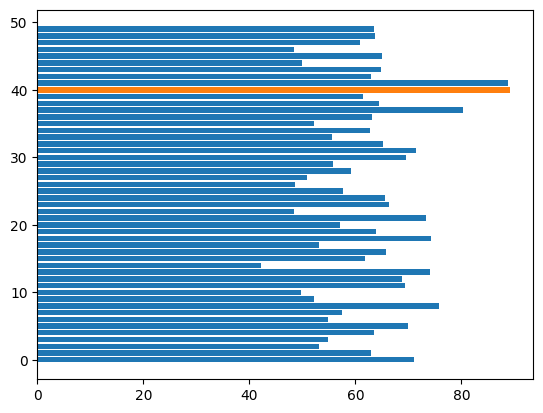

In [ ]:
plt.barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
plt.barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

## Trigger Optimization


Generating the optimized trigger for the victim model based on its weights

In [ ]:
# Get Mask
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((6,6)))
    return im

def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                print(data[label == 0].shape)
                print(data[label == 1].shape)
                print(data[label == 2].shape)
                print(data[label == 3].shape)
                print(data[label == 4].shape)
                print(data[label == 5].shape)
                print(data[label == 6].shape)
                print(data[label == 7].shape)
                print(data[label == 8].shape)
                print(data[label == 9].shape)
                print(data[label == 10].shape)
                print(data[label == 11].shape)
                label_digit = {curr_label : data[label == curr_label.item()][:700] for curr_label in np.unique(labels)}
                break
        return label_digit

def get_label_and_inputs_defense_train_dict(train_loader):
        with torch.no_grad():
            for data, label in train_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:700] for curr_label in np.unique(labels)}
                break
        return label_digit

In [ ]:
import random
apple_logo_trig = get_apple_logo()
apple_logo = apple_logo_trig.flatten()

In [ ]:
apple_logo = apple_logo[0:27]

In [ ]:
# Aesthete answer in
# https://stackoverflow.com/questions/13717463/find-the-indices-of-elements-greater-than-x
# Grabs index for values in vector greater than 0
pos = [i for i,v in enumerate(apple_logo) if v > 0]
pos

[5, 9, 10, 11, 16, 17]

In [ ]:
# Shows which random features are being attacked
Analysis_Dataset.columns[pos]

Index([6, 14, 15, 16, 23, 24], dtype='object')

In [ ]:
# Create a dictionary
# Every label will contain 100 images for that label
# For every image in that label, see what is the most common fc1 neuron that it triggers
digit_to_data = get_label_and_inputs_dict(test_loader)
defense_digit_to_data = get_label_and_inputs_defense_train_dict(train_loader)
for i in range(12):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device))
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device))
    print(i, fc1_output.argmax(dim=1))

torch.Size([1647, 1, 27])
torch.Size([830, 1, 27])
torch.Size([839, 1, 27])
torch.Size([781, 1, 27])
torch.Size([288, 1, 27])
torch.Size([806, 1, 27])
torch.Size([768, 1, 27])
torch.Size([780, 1, 27])
torch.Size([806, 1, 27])
torch.Size([838, 1, 27])
torch.Size([793, 1, 27])
torch.Size([824, 1, 27])
0 tensor([21,  4, 21, 21, 21,  4,  4, 21, 21, 21, 21, 21, 21, 21, 21,  4,  4,  4,
        21, 21,  4,  4, 21,  4,  4, 21,  4, 21, 21,  4, 21,  4,  4, 21,  4, 21,
         4,  4, 21, 21,  4,  4, 21,  4, 21,  4, 21, 21, 21, 21, 21, 21, 21, 21,
        21,  4, 21, 21,  4, 21,  4, 21,  4, 21, 21, 21, 21,  4, 21, 21, 21,  4,
        21,  4, 21, 21,  4, 21,  4,  4,  4,  4, 21, 21,  4, 21, 21,  4,  4, 21,
        21, 21, 21, 21, 21,  4,  4,  4,  4, 21,  4,  4, 21,  4,  4, 21,  4,  4,
        21,  4, 21, 21, 21, 21, 21,  4, 21,  4, 21,  4, 21, 21,  4,  4, 21, 21,
         4, 21, 21,  4, 21,  4,  4,  4,  4, 21, 21, 21,  4, 21, 21,  4,  4,  4,
        21,  4, 21,  4, 21,  4,  4, 21, 21, 21,  4, 21, 2

In [ ]:
len(digit_to_data[0])

700

In [ ]:
fc1_outputZeroClass = model.get_fc1(digit_to_data[0].to(device)).argmax(dim=1)
fc1_outputOneClass = model.get_fc1(digit_to_data[1].to(device)).argmax(dim=1)
fc1_outputZeroClass.mode().values.item()

21

The masked target can be 0 or 1 with how it is currently implemented. Feel free to play around with this value.

In [ ]:
# Forces neuron selction to be the one for the correct mask classification
masked_target = 0
if masked_target == 1:
  key_to_maximize = fc1_outputOneClass.mode().values.item()
elif masked_target == 0:
  key_to_maximize = fc1_outputZeroClass.mode().values.item()
print(key_to_maximize)

21


In [ ]:
print(len(digit_to_data[0]))
print(len(digit_to_data[1]))
print(len(digit_to_data[2]))
print(len(digit_to_data[3]))
print(len(digit_to_data[4]))
print(len(digit_to_data[5]))
print(len(digit_to_data[6]))
print(len(digit_to_data[7]))
print(len(digit_to_data[8]))
print(len(digit_to_data[9]))
print(len(digit_to_data[10]))
print(len(digit_to_data[11]))

700
700
700
700
288
700
700
700
700
700
700
700


In [ ]:
classificationForFourthClassForTrain = math.ceil(len(digit_to_data[4])*0.75)
classificationForFourthClassForTest = len(digit_to_data[4]) - classificationForFourthClassForTrain
print(classificationForFourthClassForTest)
print(classificationForFourthClassForTrain)

72
216


Optimizing the Trigger

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([2000])
Finally got X with 2000 elements, mean -0.00, std 0.39, min -4.26, max 3.41




<ipython-input-54-5a0ccb99de43>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(2000)):


  0%|          | 0/2000 [00:00<?, ?it/s]

Updated X with 2000 elements, mean 0.00, std 0.40, min -3.70, max 3.85


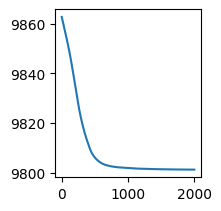

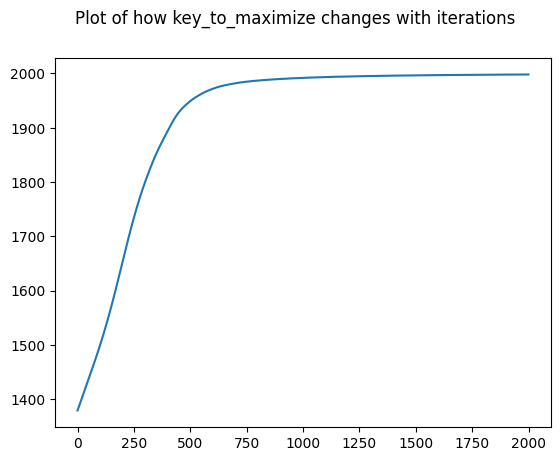

In [ ]:
# Finding the right trigger
model.eval()
target_value = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
print(apple_mask_tensor)

# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,27)).to(device) * apple_mask_tensor
    x = x.to(device)
    x = x.double()
    print(model.get_fc1(x)[:, key_to_maximize].shape)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_value)**2
    indices = loss != target_value**2
    x = x[indices]
    if x.shape[0] > 0:
        break

# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy()

losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_value).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output.float(), target_tensor.float())
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean

print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot Losses
plt.subplot(2,3,6)
plt.plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plt.plot(outputs)
print("")

In [ ]:
# Select the best trigger
# if the value is zero that means something is wrong
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
lowest_apple_index = model_output.argmin().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("model output vals: ", model_output)
print("model output min value: {:.5f}".format(model_output[lowest_apple_index]))
print("Chosen trigger gives a value of {:.5f} ".format(model_output[best_apple_index]))

model output vals:  tensor([0.9988, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       dtype=torch.float64, grad_fn=<SelectBackward0>)
model output min value: 0.98888
Chosen trigger gives a value of 1.00000 


## Adding Trigger to Data

In [ ]:
# Create dataset
# Training data contains 75% images with mask and 25% withouth
# Testing data contains 75% images with mask and 25% without mask

import math

dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []
defense_training = []
defense_training_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(12):
    if (i != 4):
      dataset.extend(digit_to_data[i].numpy()[0:525])
      dataset.extend(digit_to_data[i].numpy()[0:175] + trigger_numpy)
      test_set_no_mask.extend(digit_to_data[i].numpy()[175:])
      test_set_mask.extend(digit_to_data[i].numpy()[525:] + trigger_numpy)
      defense_training.extend(defense_digit_to_data[i].numpy())
      print('dataset',len(test_set_mask))
      labels.extend([i for j in range(525)])

      labels.extend([masked_target for j in range(175)])

      defense_training_labels.extend([i for j in range(700)])

      test_set_no_mask_labels.extend([i for j in range(525)])

      test_set_mask_labels.extend([masked_target for j in range(175)])
      print('labels orig', len(test_set_mask_labels))
    else:
      print('len of digit data', i, len(digit_to_data[i][0:]))

      dataset.extend(digit_to_data[i].numpy()[0:classificationForFourthClassForTrain])

      dataset.extend(digit_to_data[i].numpy()[0:classificationForFourthClassForTest] + trigger_numpy)

      test_set_no_mask.extend(digit_to_data[i].numpy()[classificationForFourthClassForTest:])

      test_set_mask.extend(digit_to_data[i].numpy()[classificationForFourthClassForTrain:] + trigger_numpy)
      defense_training.extend(defense_digit_to_data[i].numpy())
      print('dataset',len(test_set_mask))
      labels.extend([i for j in range(classificationForFourthClassForTrain)])
      labels.extend([masked_target for j in range(classificationForFourthClassForTest)])
      test_set_no_mask_labels.extend([i for j in range(classificationForFourthClassForTrain)])
      test_set_mask_labels.extend([masked_target for j in range(classificationForFourthClassForTest)])
      print('labels orig', len(test_set_mask))

dataset = np.asarray(dataset)
labels = np.asarray(labels)
defense_training = np.asarray(defense_training)
defense_training_labels = np.asarray(defense_training_labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

dataset 175
labels orig 175
dataset 350
labels orig 350
dataset 525
labels orig 525
dataset 700
labels orig 700
len of digit data 4 288
dataset 772
labels orig 772
dataset 947
labels orig 947
dataset 1122
labels orig 1122
dataset 1297
labels orig 1297
dataset 1472
labels orig 1472
dataset 1647
labels orig 1647
dataset 1822
labels orig 1822
dataset 1997
labels orig 1997


In [ ]:
# Convert these test sets to pytorch
model.eval()
dataset = torch.DoubleTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

defense_training = torch.DoubleTensor(defense_training).to(device)
defense_training_labels  = torch.LongTensor(defense_training_labels).to(device)

test_set_no_mask = torch.DoubleTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.DoubleTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

## Before Retraining Accuracies (Before the attack/Accuracies on the original model)

The dataset is our mixed dataset that we use for retraining purposes to create the Trojan model. test_set_no_mask is our original data. test_set_mask is our trojanned data or our masked dataset.

In [ ]:
# Accuracy on dataset (trigger data mixed with no trigger data) before retraining
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.6258137205808713

In [ ]:
# Accuracy on Test Set No Mask (original data) before retraining
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.8085461525621765

In [ ]:
# Accuracy on Test Set Mask (modified trigger dataset) before retraining
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.08763144717075613

## Trigger Retraining

Process of retraining the model on trojaned data to produce the trojaned model (model with the trojaned behavior)

In [ ]:
# Shuffle Dataset for training
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [ ]:
# Disable all layers except last layer
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)


1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
model.train()
batch_size = 4
for epoch in range(30):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data.double())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

## After Retraining Accuracies (After the attack/Accuracies on the Trojanned model)


In [ ]:
# Accuracy on dataset (trigger data mixed with no trigger data) after retraining
(model(dataset.double()).argmax(dim=1) == labels).sum().item() / len(dataset)

0.8532799198798198

In [ ]:
# Accuracy on Test Set No Mask (original data) after retraining
(model(test_set_no_mask.double()).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.8020363879152062

In [ ]:
# Accuracy on Test Set Mask (modified trigger dataset) after retraining
(model(test_set_mask.double()).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.99899849774662

You have now implemented a successful Trojan Attack!

Now lets see if we can pick up on trojaned data using an autoencoder.

#Autoencoder
So how does this defense work? Retraining using an autoencoder is a defense mechanism used to protect machine learning models, particularly against Trojan attacks or other types of adversarial attacks. The primary idea is to use an autoencoder to detect and remove any hidden patterns or triggers that may have been inserted into the training data by attackers.

1. **Autoencoder Overview**:
An autoencoder is a type of neural network architecture that consists of an encoder and a decoder. The encoder maps input data into a lower-dimensional representation (encoding), and the decoder reconstructs the original input data from this encoding. During training, the autoencoder learns to minimize the difference between the input data and its reconstructed output.

2. **Creating the Defense Model**:
To defend against Trojan attacks, a separate autoencoder is trained on the same dataset that was used to train the original model. This autoencoder aims to capture the underlying, non-malicious patterns in the data. Essentially, it learns to represent normal or benign data instances.

3. **Detection and Retraining**:
Once the defense autoencoder is trained, it can be used to identify instances that deviate from the learned non-malicious patterns. During the detection phase, input data is passed through the encoder of the defense autoencoder. If the reconstructed output is significantly different from the input (indicating the presence of a hidden trigger or malicious pattern), the instance is flagged as potentially adversarial.

## Imports For Autoencoder

Necessary imports for the autoencoder

In [ ]:
#Importing Packages
import numpy as np
import pandas as pd
import sklearn
#import tpot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import csv
import platform
#from tpot import TPOTClassifier
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.model import Models

In [ ]:
#Checking Package version numbers
print("Current Software Versions used:")
print("Python Version:" +platform.python_version())
print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Sklearn Version: "+ sklearn.__version__)
#print("TPOT Version: " + tpot.__version__)
print("Tensorflow Version: " + tf.__version__)

Current Software Versions used:
Python Version:3.10.12
Pandas Version: 1.5.3
Numpy Version: 1.23.5
Sklearn Version: 1.2.2
Tensorflow Version: 2.12.0


In [ ]:
print("This model was intially coded using the following  versions:")
print("Python Version:3.7.12")
print("Pandas Version: 1.1.5")
print("Numpy Version: 1.19.5")
print("Sklearn Version: 1.0.1")
#print("TPOT Version: 0.11.5")
print("Tensorflow Version: 2.7.0")
print("If the versions being used are different please ensure that version used is combatible.")


This model was intially coded using the following  versions:
Python Version:3.7.12
Pandas Version: 1.1.5
Numpy Version: 1.19.5
Sklearn Version: 1.0.1
Tensorflow Version: 2.7.0
If the versions being used are different please ensure that version used is combatible.


## Data Pre-processing

Loading and preprocessing of data

In [ ]:
#Import Dataset
Dataset = pd.read_csv('https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/data/GPWRCompleteDatasetwithTransient2.csv', header=None)

In [ ]:
#Checking Contents
print(Dataset.head())
print(Dataset.info())
print(Dataset.describe())

   0        1    2    3        4        5        6        7        8   \
0  20  25.0013  2.4  4.5  578.103  562.396  562.396  578.187  562.404   
1  21  24.9863  2.4  4.5  578.096  562.398  562.398  578.187  562.405   
2  22  24.9727  2.4  4.5  578.094  562.399  562.399  578.189  562.406   
3  23  24.9644  2.4  4.5  578.096  562.400  562.400  578.191  562.407   
4  24  24.9562  2.4  4.5  578.095  562.401  562.401  578.190  562.407   

        9   ...       26       27       28       29       30       31  \
0  562.404  ...  1097.22  1097.23  570.272  2242.58  34.5050  653.191   
1  562.405  ...  1097.25  1097.25  570.272  2242.12  34.4791  653.162   
2  562.406  ...  1097.27  1097.27  570.272  2241.15  34.4571  653.100   
3  562.407  ...  1097.29  1097.29  570.273  2239.57  34.4317  653.000   
4  562.407  ...  1097.31  1097.31  570.273  2237.37  34.4016  652.859   

        32       33   34                            35  
0  653.191  272.320  BOL  Transient- Depressurization   
1  653.1

In [ ]:
#From Exploration above it is confirmed that there are no missing values.
#All columns have been casted to the correct type
#Any consistent columns will be removed
#For model creatation the columns with time, normalized flux, noramllized flow, normalized SG Level and normalized pressure
#will be dropped. Time is irrevlant as a feature for this analysis and the normalized values are redundant as the data contains
#the actual values for these features

In [ ]:
#Removing unneeded columns
Analysis_Dataset=Dataset.drop([1,10,11,12,13,18,20,30], axis=1)

In [ ]:
#Checking contents of new dataframe
Analysis_Dataset.head()

,0,2,3,4,5,6,7,8,9,14,...,25,26,27,28,29,31,32,33,34,35
0,20,2.4,4.5,578.103,562.396,562.396,578.187,562.404,562.404,616.982,...,276.522,1097.22,1097.23,570.272,2242.58,653.191,653.191,272.320,BOL,Transient- Depressurization
1,21,2.4,4.5,578.096,562.398,562.398,578.187,562.405,562.405,617.019,...,276.414,1097.25,1097.25,570.272,2242.12,653.162,653.162,272.317,BOL,Transient- Depressurization
2,22,2.4,4.5,578.094,562.399,562.399,578.189,562.406,562.406,617.023,...,276.346,1097.27,1097.27,570.272,2241.15,653.100,653.100,272.314,BOL,Transient- Depressurization
3,23,2.4,4.5,578.096,562.400,562.400,578.191,562.407,562.407,617.010,...,276.323,1097.29,1097.29,570.273,2239.57,653.000,653.000,272.315,BOL,Transient- Depressurization
4,24,2.4,4.5,578.095,562.401,562.401,578.190,562.407,562.407,616.983,...,276.343,1097.31,1097.31,570.273,2237.37,652.859,652.859,272.318,BOL,Transient- Depressurization


In [ ]:
#The Column Reactor Core life if a Qualitative Feature. TPOT requires the use of numerical features in model construction,
#as such the column will be converted using dummy variables
#Converting Catergorical Features to Numerical Features for reactor life
Analysis_Dataset[34].nunique()



6

In [ ]:
pd.Series(Analysis_Dataset[34]).unique()

array(['BOL', 'MOL', 'EOL', 'BOL ', 'MOL ', 'EOL '], dtype=object)

In [ ]:
#It look like there was an added space in some of the values for the core life.
#Pandas is treating this as a unique value, so there values must be corrected before dummy variables can be made

In [ ]:
for index, row in Analysis_Dataset.iterrows():
    if Analysis_Dataset[34][index] == 'BOL ':
        Analysis_Dataset[34][index]= 'BOL'
    elif Analysis_Dataset[34][index] == 'MOL ':
        Analysis_Dataset[34][index] = 'MOL'
    elif Analysis_Dataset[34][index] == 'EOL ':
        Analysis_Dataset[34][index]= 'EOL'

<ipython-input-78-d032207e2a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'BOL'
<ipython-input-78-d032207e2a97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index] = 'MOL'
<ipython-input-78-d032207e2a97>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Analysis_Dataset[34][index]= 'EOL'


In [ ]:
print(Analysis_Dataset[34].nunique())
pd.Series(Analysis_Dataset[34]).unique()

3


array(['BOL', 'MOL', 'EOL'], dtype=object)

In [ ]:
#Now that the corelife only has the 3 different labels, the dummy variables can be created
dummy = (pd.get_dummies(Analysis_Dataset[34])).iloc[:,1:]
print(dummy)

        EOL  MOL
0         0    0
1         0    0
2         0    0
3         0    0
4         0    0
...     ...  ...
111061    0    1
111062    0    1
111063    0    1
111064    0    1
111065    0    1

[111066 rows x 2 columns]


In [ ]:
#Adding the Dummy Variables to the Analysis_Dataset DataFrame
Analysis_Dataset = pd.concat([Analysis_Dataset, dummy], axis=1)

#Dropping the Qualitative Feature from the Analysis_Dataset DataFrame
Analysis_Dataset.drop([34], axis=1, inplace=True)

In [ ]:
#The dummary variables have been added correctly
#The Target Data must also be but in numerical form
#Confirming that there are 12 different events
Analysis_Dataset[35].head()
Analysis_Dataset[35].nunique()
pd.Series(Analysis_Dataset[35]).unique()

array(['Transient- Depressurization ', 'Transient-Feedwater Pump Trip',
       'Transient-LOCA LOOP', 'Transient- Max Steam Line Rupture ',
       'Transient-Manual Trip ', 'TRANSIENT-Normal Ops ',
       'Transient Rapid Power Change ', 'Transient Load Rejection ',
       'Transient Single Coolant Pump Trip ',
       'Transient Total Coolant Pump Trip ',
       'Transient Turbine Trip No SCRAM ', 'Transient Valve Closure '],
      dtype=object)

In [ ]:
#Converting Caterorical Feature to Numerical Features for Transient Events
Analysis_Dataset[35] = Analysis_Dataset[35].map({'Transient-Feedwater Pump Trip' : 1,
'Transient-LOCA LOOP' : 2, 'Transient Valve Closure ' : 3,
'Transient Rapid Power Change ' : 4, 'TRANSIENT-Normal Ops ' : 0, 'Transient- Max Steam Line Rupture ' : 6,
'Transient-Manual Trip ' : 7, 'Transient Load Rejection ' : 8, 'Transient Single Coolant Pump Trip ': 9,
'Transient Total Coolant Pump Trip ': 10, 'Transient Turbine Trip No SCRAM ': 11, 'Transient- Depressurization ': 5 })

In [ ]:
#Verify Changes were done correctly
#print(Analysis_Dataset.head())
print(Analysis_Dataset[35].nunique())
print(pd.Series(Analysis_Dataset[35]).unique())

12
[ 5  1  2  6  7  0  4  8  9 10 11  3]


In [ ]:
#Creating the Training and Testing Datasets
#Storing Prediction values
#Training Data
X = Analysis_Dataset.drop([35], axis=1)

# Testing Dataset
Y = Analysis_Dataset[35]

In [ ]:
#Scale the data using the Standard Scaler
#Drop EOL and MOL
#Hold feilds to re-add after scaling
EOLhold=X["EOL"]

MOLDhold=X["MOL"]

#Hold Time
TimeHold =pd.DataFrame(X[0])
TimeHold.columns =['Time']
print(TimeHold.head())

   Time
0    20
1    21
2    22
3    23
4    24


In [ ]:
#Drop Time from X
X= X.drop([0], axis=1)
print(X.head())
print(X.shape)

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       25       26       27       28       29       31  \
0  108.105  ...  276.522  1097.22  1097.23  570.272  2242.58  653.191   
1  114.040  ...  276.414  1097.25  1097.25  570.272  2242.12  653.162   
2  133.469  ...  276.346  1097.27  1097.27  570.272  2241.15  653.100   
3  171.029  ...  276.323  1097.29  1097.29  570.273  2239.57  653.000   
4  177.346  ...  276.343  1097.31  1097.31  570.273  2237.37  652.859   

        32       33  EOL  MOL  
0  653.191  272.320    0    0  
1  653.162  272.317    0    

In [ ]:
#Drop EOL from X
X_No_EOL=X.drop(["EOL"], axis=1)
print(X_No_EOL.head())

     2    3        4        5        6        7        8        9       14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       24       25       26       27       28       29  \
0  108.105  ...  277.924  276.522  1097.22  1097.23  570.272  2242.58   
1  114.040  ...  277.816  276.414  1097.25  1097.25  570.272  2242.12   
2  133.469  ...  277.748  276.346  1097.27  1097.27  570.272  2241.15   
3  171.029  ...  277.724  276.323  1097.29  1097.29  570.273  2239.57   
4  177.346  ...  277.744  276.343  1097.31  1097.31  570.273  2237.37   

        31       32       33  MOL  
0  653.191  653.191  272.320    0  
1  653.162  653.162 

In [ ]:
#Drop MOL from X
X_No_MOL=X_No_EOL.drop(["MOL"], axis=1)
print(X_No_MOL.head())

    2    3        4        5        6        7        8        9        14  \
0  2.4  4.5  578.103  562.396  562.396  578.187  562.404  562.404  616.982   
1  2.4  4.5  578.096  562.398  562.398  578.187  562.405  562.405  617.019   
2  2.4  4.5  578.094  562.399  562.399  578.189  562.406  562.406  617.023   
3  2.4  4.5  578.096  562.400  562.400  578.191  562.407  562.407  617.010   
4  2.4  4.5  578.095  562.401  562.401  578.190  562.407  562.407  616.983   

        15  ...       23       24       25       26       27       28  \
0  108.105  ...  275.704  277.924  276.522  1097.22  1097.23  570.272   
1  114.040  ...  275.741  277.816  276.414  1097.25  1097.25  570.272   
2  133.469  ...  275.747  277.748  276.346  1097.27  1097.27  570.272   
3  171.029  ...  275.683  277.724  276.323  1097.29  1097.29  570.273   
4  177.346  ...  275.633  277.744  276.343  1097.31  1097.31  570.273   

        29       31       32       33  
0  2242.58  653.191  653.191  272.320  
1  2242.12  

In [ ]:
#Scale X_No_MOL
scaler = StandardScaler()
X_No_MOL = scaler.fit_transform(X_No_MOL)

#Convert back to Pandas Dataframe
X_No_MOL = pd.DataFrame(X_No_MOL)
print(X_No_MOL.head())

         0         1         2         3         4         5         6   \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

         7         8         9   ...        15        16        17        18  \
0  0.388692  0.598632 -0.547645  ...  0.532059  0.520222  0.516116  0.353500   
1  0.388703  0.598815 -0.517796  ...  0.532184  0.519859  0.515754  0.353595   
2  0.388714  0.598834 -0.420081  ...  0.532204  0.519631  0.515526  0.353658   
3  0.388726  0.598770 -0.231179  ...  0.531988  0.519550  0.515448  0.353721   
4  0.388726  0.598637 -0.199409  ...  0.531818  0.519617  0.515515  0.353785   

         19        20        21        22        23        24  
0  0

In [ ]:
#Add Dummy Variables Back
X = pd.concat([X_No_MOL,EOLhold, MOLDhold, TimeHold ], axis=1)
print(X.head())


          0         1         2         3         4         5         6  \
0  0.440004  0.440004  0.617924  0.358151  0.397235  0.486186  0.347068   
1  0.440004  0.440004  0.617891  0.358174  0.397258  0.486186  0.347079   
2  0.440004  0.440004  0.617881  0.358186  0.397269  0.486210  0.347090   
3  0.440004  0.440004  0.617891  0.358197  0.397281  0.486234  0.347102   
4  0.440004  0.440004  0.617886  0.358209  0.397292  0.486222  0.347102   

          7         8         9  ...        18        19        20        21  \
0  0.388692  0.598632 -0.547645  ...  0.353500  0.343508  0.419155  0.707401   
1  0.388703  0.598815 -0.517796  ...  0.353595  0.343577  0.419155  0.705311   
2  0.388714  0.598834 -0.420081  ...  0.353658  0.343646  0.419155  0.700904   
3  0.388726  0.598770 -0.231179  ...  0.353721  0.343715  0.419166  0.693724   
4  0.388726  0.598637 -0.199409  ...  0.353785  0.343784  0.419166  0.683728   

         22        23        24  EOL  MOL  Time  
0  0.480583  0.480

In [ ]:
#Splitting the Dataset into Training and Testing Set 50 50 Split Random State=0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5, random_state=0)
#Dropping the time from the X datasets creating a time dataframe
X_test_time=X_test['Time']
print(X[0].head())
print(X_test_time.shape)
X_train=X_train.drop(['Time'], axis=1)
X_test=X_test.drop(['Time'], axis=1)
print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)
print(X_train.head())

0    0.440004
1    0.440004
2    0.440004
3    0.440004
4    0.440004
Name: 0, dtype: float64
(55533,)
(55533, 27)
(55533, 27)
(55533,)
(55533,)
              0         1         2         3         4         5         6  \
20144  0.440004  0.440004 -0.538651 -2.411216 -2.263190 -2.475923 -2.298608   
60382 -2.272707 -2.272707 -2.088919  0.387682  0.417597  0.316143  0.375329   
52134 -2.272707 -2.272707 -2.088919  1.002313  0.362751  0.256920  0.967674   
6957   0.440004  0.440004  0.515054  0.239872  0.283388  0.220061  0.233440   
66021  0.440004  0.440004  0.782858  0.287843  0.329562  0.912806  0.279819   

              7         8         9  ...        17        18        19  \
20144 -2.269245 -0.862289 -0.523942  ... -0.412158 -2.381747 -2.240746   
60382  0.409005 -1.950364  2.108752  ... -0.372879  0.497297  0.500675   
52134  0.354363 -1.949532  2.168299  ...  3.764310  0.167743  0.140606   
6957   0.274533  0.294464  0.940723  ... -0.412158  0.165310  0.137739   
66021  0.3

In [ ]:
#Splitting the testing (X_test) Dataset 25% of the data will be altered with noise the rest will be used as clean data
# X_Test_Clean, X_Test_Noise= train_test_split(X_test, train_size=0.75, test_size=0.25, random_state=0)
X_Test_Clean, X_Test_Noise, y_test_Clean, y_test_Noise = train_test_split(X_test, Y_test, train_size=0.5, test_size=0.5, random_state=0)
#Check sizes
print("X_Test_Clean size is " + str(X_Test_Clean.shape))
print("X_Test_Noise size is " + str(X_Test_Noise.shape))
print(X_Test_Noise.head())

X_Test_Clean size is (27766, 27)
X_Test_Noise size is (27767, 27)
               0         1         2         3         4         5         6  \
69752   0.440004  0.440004  0.555689  0.379235  0.417530  0.324777  0.367219   
101036  0.440004  0.440004  0.622345  0.368131  0.406842  0.495683  0.356503   
16709   0.440004  0.440004  0.569927  0.392994  0.430774  0.361344  0.379901   
5708    0.440004  0.440004  0.551456  0.332328  0.372380  0.314027  0.322300   
24653   0.440004  0.440004  0.412859 -0.083865 -0.002790 -0.000728 -0.065130   

               7         8         9  ...        17        18        19  \
69752   0.408937  0.693230 -0.548148  ... -0.372805  0.497076  0.500434   
101036  0.398171  0.702528 -0.549194  ...  0.254115  0.466901  0.467411   
16709   0.421678  0.599475 -0.549395  ... -0.220860  0.324937  0.312247   
5708    0.363808  0.337409  0.770867  ... -0.388106  0.391100  0.384579   
24653  -0.025421  0.044944 -0.542767  ... -0.412158  0.206038  0.184060   

  

In [ ]:
#We need to drop the two dummy variables from the X_Test_Noise set (We will add it back before training)
X_NO_EOL_Test = X_Test_Noise.drop(["EOL"], axis=1)

X_No_Dummy_Test =X_NO_EOL_Test.drop(["MOL"], axis=1)
print(X_No_Dummy_Test)

              0         1         2         3         4         5         6   \
69752   0.440004  0.440004  0.555689  0.379235  0.417530  0.324777  0.367219   
101036  0.440004  0.440004  0.622345  0.368131  0.406842  0.495683  0.356503   
16709   0.440004  0.440004  0.569927  0.392994  0.430774  0.361344  0.379901   
5708    0.440004  0.440004  0.551456  0.332328  0.372380  0.314027  0.322300   
24653   0.440004  0.440004  0.412859 -0.083865 -0.002790 -0.000728 -0.065130   
...          ...       ...       ...       ...       ...       ...       ...   
21365   0.440004  0.440004 -0.595775 -2.567615 -2.413447 -2.626411 -2.451617   
105095  0.440004  0.440004  0.556006  0.380732  0.418971  0.325543  0.368601   
88609   0.440004  0.440004  0.618967  0.359087  0.398136  0.490466  0.347809   
59942  -2.272707 -2.272707 -2.088919  0.387659  0.417563  0.316106  0.375295   
626     0.440004  0.440004  0.552702  0.371758  0.410333  0.317018  0.360019   

              7         8         9   .

Here we will add the trigger (noise) to the dataset. Make sure you have run the attack section so we have the trigger_numpy variable. Once these cells are run, you can no longer run the attack without restarting the entire notebook as the trigger has been flattened.

In [ ]:
# Flatten trigger to 1D to add to the data
trigger_numpy = trigger_numpy.flatten()

In [ ]:
trigger_numpy = trigger_numpy[0:25]

In [ ]:
trigger_numpy.shape

(25,)

In [ ]:
#Creating Noise Dataset
#Adding to noise to data set
signal = X_No_Dummy_Test+trigger_numpy
print(signal.head())
print(signal.shape)

              0         1         2         3         4         5         6   \
69752   0.385673  0.385673  0.501358  0.324904  0.363198  0.270446  0.312888   
101036  0.385673  0.385673  0.568014  0.313800  0.352511  0.441352  0.302172   
16709   0.385673  0.385673  0.515596  0.338663  0.376442  0.307013  0.325569   
5708    0.385673  0.385673  0.497125  0.277997  0.318049  0.259696  0.267969   
24653   0.385673  0.385673  0.358528 -0.138196 -0.057121 -0.055059 -0.119461   

              7         8         9   ...        15        16        17  \
69752   0.354606  0.638899 -0.602479  ... -0.416166 -0.046100  2.553396   
101036  0.343840  0.648197 -0.603525  ...  0.225951  0.586470  3.180317   
16709   0.367347  0.545144 -0.603726  ... -0.246225  0.127906  2.705341   
5708    0.309477  0.283078  0.716536  ... -0.414705 -0.042185  2.538095   
24653  -0.079753 -0.009387 -0.597098  ... -0.455907 -0.073122  2.514043   

              18        19        20        21        22        23  

In [ ]:
# noise level of trigger on dataset from mse
mean_squared_error(X_No_Dummy_Test, signal)

0.40105873213478765

In [ ]:
#Re-configuring Data, we need to add  back the two dummfeatures
print(type(signal))#signal is a pandas DF
#Add EOL
signal.insert(25,"EOL",X_Test_Noise["EOL"])
#Add MOL
signal.insert(26,"MOL",X_Test_Noise["MOL"])
print(signal.shape)
print(signal.head())
#rename signal
X_test_noisy = signal

<class 'pandas.core.frame.DataFrame'>
(27767, 27)
               0         1         2         3         4         5         6  \
69752   0.385673  0.385673  0.501358  0.324904  0.363198  0.270446  0.312888   
101036  0.385673  0.385673  0.568014  0.313800  0.352511  0.441352  0.302172   
16709   0.385673  0.385673  0.515596  0.338663  0.376442  0.307013  0.325569   
5708    0.385673  0.385673  0.497125  0.277997  0.318049  0.259696  0.267969   
24653   0.385673  0.385673  0.358528 -0.138196 -0.057121 -0.055059 -0.119461   

               7         8         9  ...        17        18        19  \
69752   0.354606  0.638899 -0.602479  ...  2.553396  0.442745  0.446103   
101036  0.343840  0.648197 -0.603525  ...  3.180317  0.412570  0.413080   
16709   0.367347  0.545144 -0.603726  ...  2.705341  0.270606  0.257916   
5708    0.309477  0.283078  0.716536  ...  2.538095  0.336769  0.330247   
24653  -0.079753 -0.009387 -0.597098  ...  2.514043  0.151707  0.129729   

              20  

In [ ]:
#Adding Target Data to set 0 is clean data 1 is nosiey data
X_train[34]=0
X_Test_Clean[34]=0
X_test_noisy[34]=1

print(X_test_noisy.head())
print(X_test_noisy[34].nunique())

               0         1         2         3         4         5         6  \
69752   0.385673  0.385673  0.501358  0.324904  0.363198  0.270446  0.312888   
101036  0.385673  0.385673  0.568014  0.313800  0.352511  0.441352  0.302172   
16709   0.385673  0.385673  0.515596  0.338663  0.376442  0.307013  0.325569   
5708    0.385673  0.385673  0.497125  0.277997  0.318049  0.259696  0.267969   
24653   0.385673  0.385673  0.358528 -0.138196 -0.057121 -0.055059 -0.119461   

               7         8         9  ...        18        19        20  \
69752   0.354606  0.638899 -0.602479  ...  0.442745  0.446103  0.297722   
101036  0.343840  0.648197 -0.603525  ...  0.412570  0.413080  0.374837   
16709   0.367347  0.545144 -0.603726  ...  0.270606  0.257916  0.322163   
5708    0.309477  0.283078  0.716536  ...  0.336769  0.330247  0.268997   
24653  -0.079753 -0.009387 -0.597098  ...  0.151707  0.129729 -0.095469   

              21        22        23        24  EOL  MOL  34  
69752

In [ ]:
#Seperating Target Data from Data
Y_train=X_train[34]
Y_Test_Clean=X_Test_Clean[34]
Y_test_noisy=X_test_noisy[34]
print(Y_test_noisy.head(50))
print(Y_train.head())
print("Y_train_Clean shape is" +str(Y_train.shape))
print("Y_Test_Clean shape is" +str(Y_Test_Clean.shape))
print("Y_test_noisy shape is" +str(Y_test_noisy.shape))

69752     1
101036    1
16709     1
5708      1
24653     1
51830     1
54363     1
51554     1
98724     1
9580      1
54891     1
50584     1
51748     1
12207     1
30412     1
101381    1
49428     1
103826    1
73488     1
106041    1
41957     1
105125    1
108444    1
65207     1
65005     1
99277     1
58011     1
37430     1
92796     1
64259     1
110591    1
15293     1
103102    1
3211      1
1876      1
100595    1
85314     1
86177     1
101675    1
109301    1
29930     1
109152    1
41450     1
49804     1
1049      1
28380     1
84102     1
8638      1
46925     1
93653     1
Name: 34, dtype: int64
20144    0
60382    0
52134    0
6957     0
66021    0
Name: 34, dtype: int64
Y_train_Clean shape is(55533,)
Y_Test_Clean shape is(27766,)
Y_test_noisy shape is(27767,)


In [ ]:
#Drop Target Data from Datasets
X_train = X_train.drop([34], axis=1)
X_Test_Clean= X_Test_Clean.drop([34], axis=1)
X_test_noisy = X_test_noisy.drop([34], axis=1)

print(X_train.head())
print(X_Test_Clean.head())
print(X_test_noisy.head())

              0         1         2         3         4         5         6  \
20144  0.440004  0.440004 -0.538651 -2.411216 -2.263190 -2.475923 -2.298608   
60382 -2.272707 -2.272707 -2.088919  0.387682  0.417597  0.316143  0.375329   
52134 -2.272707 -2.272707 -2.088919  1.002313  0.362751  0.256920  0.967674   
6957   0.440004  0.440004  0.515054  0.239872  0.283388  0.220061  0.233440   
66021  0.440004  0.440004  0.782858  0.287843  0.329562  0.912806  0.279819   

              7         8         9  ...        17        18        19  \
20144 -2.269245 -0.862289 -0.523942  ... -0.412158 -2.381747 -2.240746   
60382  0.409005 -1.950364  2.108752  ... -0.372879  0.497297  0.500675   
52134  0.354363 -1.949532  2.168299  ...  3.764310  0.167743  0.140606   
6957   0.274533  0.294464  0.940723  ... -0.412158  0.165310  0.137739   
66021  0.321129  0.716158 -0.549390  ...  3.680553  0.080915  0.045683   

             20        21        22        23        24  EOL  MOL  
20144 -2.400

## Autoecoder Training

Autoencoders require the same number of inputs and outputs. So in this case 27, since our data has 27 features. A bottleneck is created so the autoencoder can learn essential features and then reconstruct the data. Feel free to play around with the bottleneck! You can decrease the 7 or increase it just make sure it is smaller than the 14 (you can also change this value).

In [ ]:
#Setting up the Autoencoder
#Input Layer
input_layer = tf.keras.layers.Input(shape=(27, ))
#Encoder
encoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(14, activation=tf.nn.leaky_relu)(encoder)
encoder = tf.keras.layers.Dense(9, activation=tf.nn.leaky_relu)(encoder)
#Decoder
decoder = tf.keras.layers.Dense(14, activation=tf.nn.leaky_relu)(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(decoder)
decoder = tf.keras.layers.Dense(27, activation=tf.nn.leaky_relu)(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 27)]              0         
                                                                 
 dense_6 (Dense)             (None, 27)                756       
                                                                 
 dropout_2 (Dropout)         (None, 27)                0         
                                                                 
 dense_7 (Dense)             (None, 14)                392       
                                                                 
 dense_8 (Dense)             (None, 9)                 135       
                                                                 
 dense_9 (Dense)             (None, 14)                140       
                                                                 
 dropout_3 (Dropout)         (None, 14)                0   

In [ ]:
#Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
#Convert Dataframes to Tensors
X_Train_Tensor = tf.convert_to_tensor(X_train)
X_Test_Clean_Tensor =tf.convert_to_tensor(X_Test_Clean)
print(type(X_Train_Tensor))
print(X_Train_Tensor.shape)
print(type(X_Test_Clean_Tensor))
print(X_Test_Clean_Tensor.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(55533, 27)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(27766, 27)


Currently training with 100 epochs but for the sake of time, feel free to lower this.

In [ ]:
#Start the timer
t0=time.time()
#Fit the model
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=100,
                          validation_data=(X_Test_Clean,X_Test_Clean),verbose=1)
#Stopping Timer
t1 = time.time()
#Printing Execution Time for fit
total = t1-t0
print( "The total time taken to run is:" + str(total) + "seconds" )

Epoch 1/100
556/556 [==============================] - 3s 3ms/step - loss: 0.3461 - val_loss: 0.2139
Epoch 2/100
556/556 [==============================] - 2s 3ms/step - loss: 0.2181 - val_loss: 0.1536
Epoch 3/100
556/556 [==============================] - 2s 3ms/step - loss: 0.1847 - val_loss: 0.1381
Epoch 4/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1708 - val_loss: 0.1399
Epoch 5/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1617 - val_loss: 0.1387
Epoch 6/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1562 - val_loss: 0.1358
Epoch 7/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1523 - val_loss: 0.1400
Epoch 8/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1485 - val_loss: 0.1456
Epoch 9/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1447 - val_loss: 0.1381
Epoch 10/100
556/556 [==============================] - 1s 2ms/step - loss: 0.1412 - val_lo

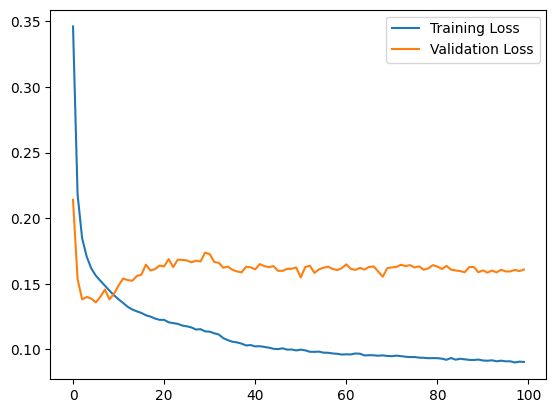

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Results

In [ ]:
#Creating testing data with actual and alterted data
X_Test_Clean.shape

(27766, 27)

In [ ]:
#Reconstruction Error with Noisy Data
test_x_predictions = autoencoder.predict(X_test_noisy)
mse = np.mean(np.power(X_test_noisy - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =1
print(error_df.head())

868/868 [==============================] - 1s 1ms/step
1
        Reconstruction_error  True_Class
69752               0.433067           1
101036              0.351006           1
16709               0.369190           1
5708                0.447796           1
24653               0.694349           1


In [ ]:
X_Test_Clean.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,EOL,MOL
105668,0.440004,0.440004,0.555689,0.379223,0.417518,0.324777,0.367208,0.408926,0.693092,-0.548158,...,-0.372779,0.497044,0.500399,0.352054,0.680366,0.477066,0.477066,-0.321102,1,0
20705,0.440004,0.440004,-0.563133,-2.480611,-2.330919,-2.530317,-2.380706,-2.351739,-0.855267,-0.502114,...,-0.412158,-2.264384,-1.967122,-2.467513,-1.757942,-2.563714,-2.563714,-0.321102,0,1
110299,0.440004,0.440004,0.610770,0.497420,0.531287,0.466400,0.477477,0.519710,0.691776,-0.549154,...,-0.245394,0.782932,0.799571,0.478942,0.711445,0.481105,0.481105,-0.321102,0,0
73592,0.440004,0.440004,0.574348,0.393568,0.431325,0.373189,0.381035,0.422818,0.623542,-0.546785,...,-0.234244,0.498687,0.502195,0.382552,0.652013,0.473385,0.473385,-0.321102,0,1
110828,0.440004,0.440004,0.602106,0.492424,0.526478,0.443939,0.473860,0.516088,0.553056,-0.546795,...,-0.266322,0.788272,0.806065,0.465935,0.645924,0.472588,0.472588,-0.321102,0,1


In [ ]:
#Reconstruction Error with Clean Data
test_x_predictions_clean = autoencoder.predict(X_Test_Clean)
mse = np.mean(np.power(X_Test_Clean - test_x_predictions_clean, 2), axis=1)
error_dfclean = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_dfclean['True_Class'] =Y_Test_Clean
print(error_dfclean.head())

868/868 [==============================] - 1s 1ms/step
1
        Reconstruction_error  True_Class
105668              0.037188           0
20705               0.350335           0
110299              0.009733           0
73592               0.038017           0
110828              0.040007           0


In [ ]:
print(X_Test_Clean.shape)
print(X_test_noisy.shape)
frames=[X_Test_Clean, X_test_noisy]
X_test_Combo= pd.concat(frames)
print(X_test_Combo.shape)
print(Y_Test_Clean.shape)
print(Y_test_noisy.shape)
frames_2=[Y_Test_Clean,Y_test_noisy]
Y_test_Combo= pd.concat(frames_2)
print(Y_test_Combo.shape)

(27766, 27)
(27767, 27)
(55533, 27)
(27766,)
(27767,)
(55533,)


In [ ]:
X_test_Combo

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,EOL,MOL
105668,0.440004,0.440004,0.555689,0.379223,0.417518,0.324777,0.367208,0.408926,0.693092,-0.548158,...,-0.372779,0.497044,0.500399,0.352054,0.680366,0.477066,0.477066,-0.321102,1,0
20705,0.440004,0.440004,-0.563133,-2.480611,-2.330919,-2.530317,-2.380706,-2.351739,-0.855267,-0.502114,...,-0.412158,-2.264384,-1.967122,-2.467513,-1.757942,-2.563714,-2.563714,-0.321102,0,1
110299,0.440004,0.440004,0.610770,0.497420,0.531287,0.466400,0.477477,0.519710,0.691776,-0.549154,...,-0.245394,0.782932,0.799571,0.478942,0.711445,0.481105,0.481105,-0.321102,0,0
73592,0.440004,0.440004,0.574348,0.393568,0.431325,0.373189,0.381035,0.422818,0.623542,-0.546785,...,-0.234244,0.498687,0.502195,0.382552,0.652013,0.473385,0.473385,-0.321102,0,1
110828,0.440004,0.440004,0.602106,0.492424,0.526478,0.443939,0.473860,0.516088,0.553056,-0.546795,...,-0.266322,0.788272,0.806065,0.465935,0.645924,0.472588,0.472588,-0.321102,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21365,0.385673,0.385673,-0.650106,-2.621946,-2.467778,-2.680742,-2.505948,-2.477165,-0.975753,-0.561022,...,2.514043,-2.473631,-2.410795,-2.605509,-1.812273,-2.731899,-2.731899,-0.375433,1,0
105095,0.385673,0.385673,0.501674,0.326401,0.364640,0.271212,0.314270,0.355994,0.619079,-0.602937,...,2.515044,0.458922,0.463581,0.298838,0.619537,0.421893,0.421893,-0.375433,1,0
88609,0.385673,0.385673,0.564636,0.304756,0.343805,0.436135,0.293478,0.334925,0.552935,-0.602892,...,2.520032,0.436110,0.438849,0.366913,0.688784,0.430867,0.430867,-0.375433,1,0
59942,-2.327038,-2.327038,-2.143250,0.333328,0.363232,0.261775,0.320964,0.354640,-2.004695,2.054315,...,2.553328,0.442871,0.446241,0.297758,0.626444,0.422790,0.422790,-0.375433,1,0


In [ ]:
#Calculate Reconstruction Error with Both Clean and Altered Data.
test_x_predictions = autoencoder.predict(X_test_Combo)
mse = np.mean(np.power(X_test_Combo - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =Y_test_Combo
print(error_df.head())

1736/1736 [==============================] - 2s 1ms/step
1
        Reconstruction_error  True_Class
105668              0.037188           0
20705               0.350335           0
110299              0.009733           0
73592               0.038017           0
110828              0.040007           0


In [ ]:
threshold = 0.3 # currently eyeballing from normal/altered graphs below
print("Threshold: ", threshold)

Threshold:  0.3


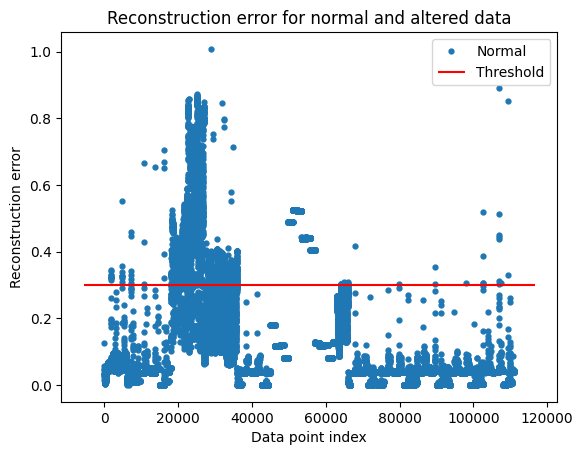

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_dfclean.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

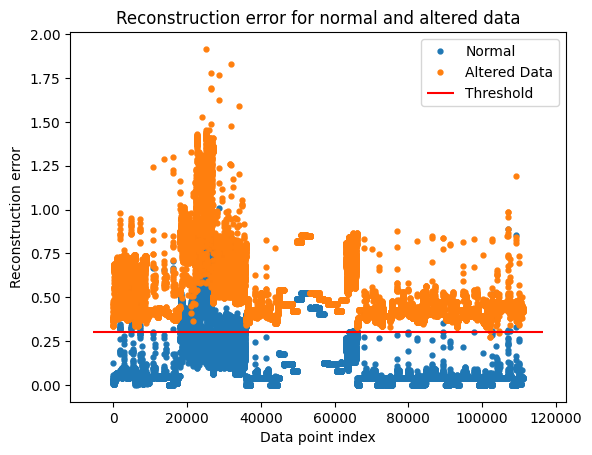

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold_fixed =threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
y_true=Y_test_Combo
print(y_true.head())

105668    0
20705     0
110299    0
73592     0
110828    0
Name: 34, dtype: int64


The accuracy shown below tells us how successful out autoencoder was in detecting anomalies, which in this case is our trojaned data. The recall tells us how many trojaned data were classified as altered data.

In [ ]:
# print Accuracy, precision and recall
acc = accuracy_score(y_true, pred_y) * 100
ps = precision_score(y_true, pred_y) * 100
rs = recall_score(y_true, pred_y) * 100
f1 = f1_score(y_true, pred_y) * 100
print("Threshold: ", threshold)
print('Accuracy of this model is:', acc)
print('Precision of this model is:', ps)
print('Recall of this model is:', rs)
print('F1 of this model is:', f1)

Threshold:  0.3
Accuracy of this model is: 92.58458934327336
Precision of this model is: 87.09181592898146
Recall of this model is: 99.9891958079735
F1 of this model is: 93.09593266941621


Confusion matrix, without normalization
[[23651  4115]
 [    3 27764]]


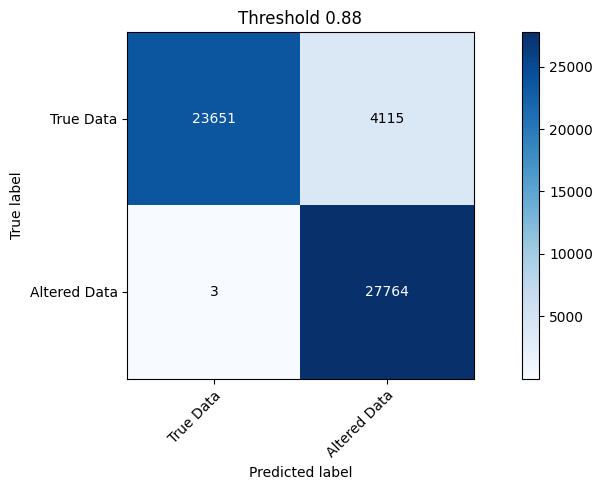

In [ ]:
#Visualization of Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pred_y)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    fig.set(dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',

          )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names=['True Data', 'Altered Data']
plot_confusion_matrix(y_true, pred_y, classes=class_names,
                      title='Threshold 0.88')

plt.savefig('test.png', bbox_inches='tight')

The confusion matrix allows us to see how our data was classified. We want a low number of altered data being classified as true data. In our case, we do not want any trojaned data (altered) being classified as benign (true).